Importing Dependencies and Data

In [7]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd

csv_filepath = r"D:\Users\koust\Documents\SEM-6\EEE F376\rfnp2d3kjp-1\Dataset on Hourly Load Profiles for 24 Facilities (8760 hours)\Commercial-275-bed Hospital.csv"
with open(csv_filepath) as f:
    reader = csv.reader(f)
    lst = list(reader)
lst.pop(0)

n=512
load_profile = np.asarray(lst).astype('float64').flatten()
load_profile = np.array(load_profile[:n])

Function to calculate New Load Profile

In [2]:
def NewProf(threshold, load_profile, target_battery, n):
    new_profile = np.array([], dtype='float32')
    max_cap = target_battery
    ess_cap = max_cap
    abs_charge = np.array([], dtype='float32')
    discharge_rate = 0.2*max_cap #kWh
    charge_rate = 0.2*max_cap #kWh
    for i in range(n):
        if (load_profile[i] - threshold) < 0 :
            if ess_cap >= max_cap :
                new_profile = np.append(new_profile, [load_profile[i]])
                ess_cap = max_cap
                abs_charge = np.append(abs_charge, [ess_cap])
            elif ess_cap < max_cap :
                if (threshold - load_profile[i]) < charge_rate :
                    new_profile = np.append(new_profile, [threshold])
                    ess_cap += (threshold - load_profile[i])
                    abs_charge = np.append(abs_charge, [ess_cap])
                else :
                    new_profile = np.append(new_profile, [load_profile[i]+charge_rate])
                    ess_cap += charge_rate
                    abs_charge = np.append(abs_charge, [ess_cap])
        elif load_profile[i] >= threshold :
            diff = (load_profile[i]-threshold)
            if diff <= ess_cap-(0.1)*max_cap :
                ess_cap -= diff
                abs_charge = np.append(abs_charge, [ess_cap])
                new_profile = np.append(new_profile, [threshold])
            elif diff > ess_cap-(0.1)*max_cap :
                new_profile = np.append(new_profile, [threshold+(diff-(ess_cap-(0.1)*max_cap))])
                ess_cap = (0.1)*max_cap
                abs_charge = np.append(abs_charge, [ess_cap])
    return new_profile, abs_charge

Function to calculate Electrical Energy Charges

In [3]:
def CostCalc(load_profile,n):
    a = 100 # fixed charge
    b = 20 # demand fee kW/hour 
    c = 4 # hourly load fee kWh
    cost = a + max(load_profile)*b
    for i in range(n):
        cost += load_profile[i]*c
    return cost  

Function to calculate Battery Capacity

In [4]:
def batCapCalc(load_profile,target_thresh,n):
    tempCap = np.array([], dtype='int32')
    m = int(n/24)
    for i in range(m):
        temp = 0
        for j in range(24*i,24*(i+1)):
            if load_profile[j] > target_thresh:
                temp += load_profile[j] - target_thresh
        buff_cap = 0.1*temp
        tempCap = np.append(tempCap, [buff_cap + temp])
    BattCap = max(tempCap)
    return BattCap

Function to calculate Charging/Discharging Cycles

In [5]:
def cyclesCalc(load_profile,new_profile,target_battery,n):
    counter = np.array([], dtype='int32')
    c = 0
    temp = 0
    for i in range(n):
        if temp < (2*target_battery):
            temp += abs(load_profile[i] - new_profile[i])
            counter = np.append(counter,[c])
        elif temp >= (2*target_battery): 
            temp = 0
            c += 1
            counter = np.append(counter,[c])
    return counter

Main

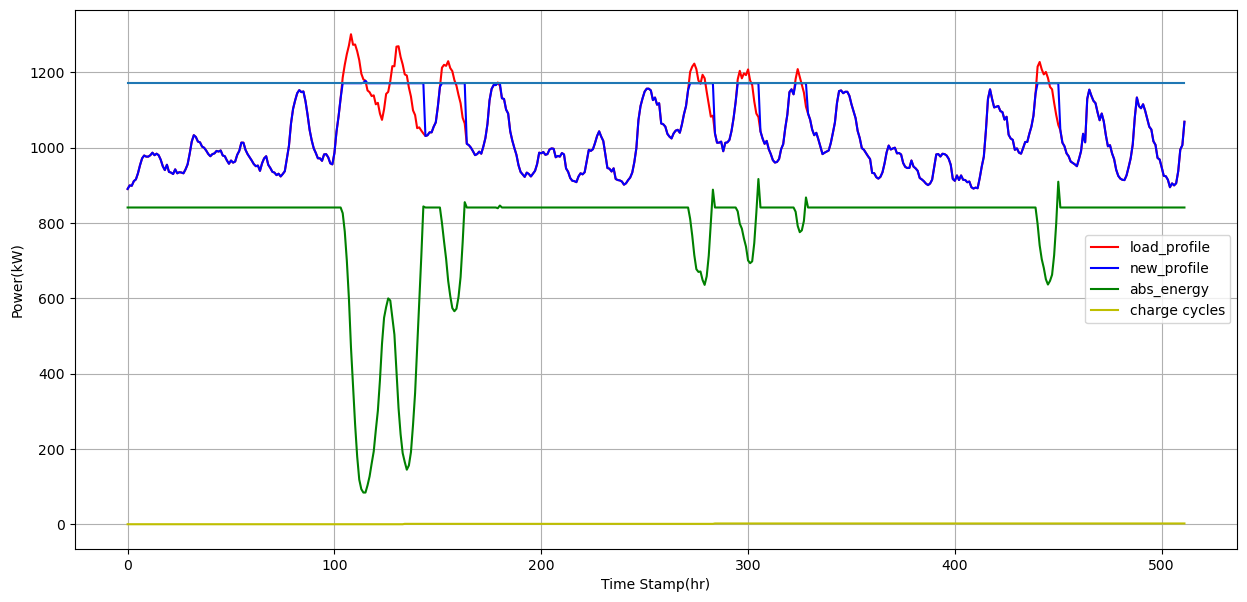

The targeted threshold for peak-shaving is 1171.233 kW i.e. 10.0 %.
The calculated battery capacity is 841.1634000000007 kWh.
The number of charge/discharge cycles the battery undergoes is 2.
The tariff imposed on the old profile is Rs.2142082.360000001.
The tariff imposed on the old profile is Rs.2140570.0357600017.
The profit percentage attained is 0.0706006579503813 %.


In [9]:
if __name__ == "__main__":
    target_peak_shave = 0.1 # 10% peak-shaving targeted
    target_thresh = max(load_profile) - target_peak_shave*max(load_profile)
    target_battery = batCapCalc(load_profile,target_thresh,n)

    new_profile, abs_charge = NewProf(target_thresh, load_profile, target_battery, n)
    charge_cycles = cyclesCalc(load_profile,new_profile,target_battery,n)
    numCycles = charge_cycles[-1]

    old_cost = CostCalc(load_profile,n)
    new_cost = CostCalc(new_profile,n)
    percent_saving = (abs(new_cost - old_cost)/old_cost)*100

    x=np.arange(0,n,1)
    thresharr = np.ones(n)*target_thresh
    plt.figure(figsize=(15,7))
    plt.plot(x, load_profile, 'r', label='load_profile')
    plt.plot(x, new_profile, 'b', label='new_profile')
    plt.plot(x, abs_charge, 'g', label='abs_energy')
    plt.plot(x, thresharr)
    plt.plot(x, charge_cycles, 'y', label='charge cycles')
    plt.legend(loc="center right")
    plt.xlabel("Time Stamp(hr)")
    plt.ylabel("Power(kW)")
    plt.grid()
    plt.show()

    print(f"The targeted threshold for peak-shaving is {target_thresh} kW i.e. {target_peak_shave*100} %.")
    print(f"The calculated battery capacity is {target_battery} kWh.")
    print(f"The number of charge/discharge cycles the battery undergoes is {numCycles}.")
    print(f"The tariff imposed on the old profile is Rs.{old_cost}.")
    print(f"The tariff imposed on the old profile is Rs.{new_cost}.")
    print(f"The profit percentage attained is {percent_saving} %.")